In [86]:
import numpy as np
import torch
import torch.nn as nn
import os

from PIL import Image, ImageOps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from make_gif_from_folder import make_gif


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(0)
print(device)

width, height = 60, 80
pix_num = width * height


cuda:0


In [87]:
class Net(nn.Module):
    def __init__(self, lr, img_path):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 4), nn.ELU(),
            nn.Linear(4, 8), nn.ELU(),
            nn.Linear(8, 16), nn.ELU(),
            nn.Linear(16, 32), nn.ELU(),
            # nn.Linear(32, 64), nn.ELU(),
            # nn.Linear(64, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 128), nn.ELU(),
            # nn.Linear(128, 64), nn.ELU(),
            # nn.Linear(64, 32), nn.ELU(),
            nn.Linear(32, 16), nn.ELU(),
            nn.Linear(16, 8), nn.Tanh(),
            nn.Linear(8, 1), nn.Tanh())
        
        self.lr = lr
        self.img_path = img_path
        
    def forward(self, x):
        #x = x.cuda()
        output = self.net(x)
        return output


In [88]:
def get_grayscale_image_arr(path):
    im = ImageOps.grayscale(Image.open(path))
    image_array = np.array(im).astype(int)
    return image_array


In [89]:
model = Net(lr=1e-3, img_path='./imgs/5_test.bmp')
model.to(device)
model

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=16, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=16, out_features=8, bias=True)
    (11): Tanh()
    (12): Linear(in_features=8, out_features=1, bias=True)
    (13): Tanh()
  )
)

In [90]:
img_arr = get_grayscale_image_arr(model.img_path)
bound_length = len(np.where(img_arr < 255)[0])
print(f'Total pixels: {pix_num}, bound length: {bound_length}')

Total pixels: 4800, bound length: 334


In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr=model.lr, weight_decay=1e-3)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True, patience=10000)

In [92]:
def loss_fn(y):
    first_integral = (y[np.where(img_arr == 255)].abs()).sum() / (pix_num - bound_length) # хочу НЕ границу +-1
    #second_integral = y.abs().sum()
    bound_intgegral = ((y[np.where(img_arr < 255)]) ** 2).sum() / bound_length # хочу на границе 0
    return bound_intgegral - first_integral + 1


In [93]:
def train_model(model, num_epochs):
    loss_trace = []

    batch = torch.tensor(np.array(np.stack(np.indices((width, height)), axis=2)).reshape(-1,2), device=device).float()
    batch[:, 0] -= batch[:, 0].mean()
    batch[:, 0] /= batch[:, 0].max()
    batch[:, 1] -= batch[:, 1].mean()
    batch[:, 1] /= batch[:, 1].max()

    dir_path = 'epoch_outs'
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    for epoch in range(num_epochs):
        y_pred = model(batch)
        y_pred = y_pred.view((width, height))
        
        optimizer.zero_grad() 
        
        loss = loss_fn(y_pred) 
        loss_trace.append(loss.item())
        loss.backward()
         
        optimizer.step() 
        #scheduler.step(loss)
        
        if (epoch + 1) % 100 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.plot(loss_trace)
            plt.subplot(1, 2, 2)
            plt.imshow(y_pred.cpu().detach().numpy(), cmap='gray', vmin=-1, vmax=1)
            plt.title(f'Epoch {epoch + 1}')
            plt.savefig(dir_path + '/epoch%06d.png' % (epoch + 1))
            plt.show()
            
    return y_pred

In [94]:
# for g in optimizer.param_groups:
#     g['lr'] = 0.01

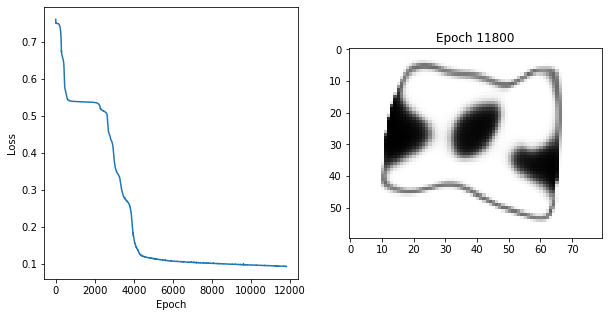

KeyboardInterrupt: 

In [95]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
y_pred = train_model(model=model, num_epochs=100000)

In [41]:
make_gif(dir_path='./epoch_outs', gifname='best_rect')

In [19]:
batch = torch.FloatTensor(np.stack(np.indices((60, 80)), axis=2).reshape(-1,2))
batch

tensor([[ 0.,  0.],
        [ 0.,  1.],
        [ 0.,  2.],
        ...,
        [59., 77.],
        [59., 78.],
        [59., 79.]])

In [22]:
batch[:, 0] -= batch[:, 0].mean()
batch[:, 0] /= batch[:, 0].max()
batch[:, 1] -= batch[:, 1].mean()
batch[:, 1] /= batch[:, 1].max()

In [24]:
print(batch)

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9747],
        [-1.0000, -0.9494],
        ...,
        [ 1.0000,  0.9494],
        [ 1.0000,  0.9747],
        [ 1.0000,  1.0000]])


In [12]:
batch = torch.FloatTensor(np.stack(np.indices((60, 80)), axis=2).reshape(-1,2))
batch[:, 0] -= batch[:, 0].mean()
batch[:, 0] /= 0.5*(batch[:, 0].max())
batch[:, 1] -= batch[:, 1].mean()
batch[:, 1] /= 0.5*(batch[:, 1].max())

In [13]:
batch

tensor([[-2.0000, -2.0000],
        [-2.0000, -1.9494],
        [-2.0000, -1.8987],
        ...,
        [ 2.0000,  1.8987],
        [ 2.0000,  1.9494],
        [ 2.0000,  2.0000]])

In [14]:
model(batch)

tensor([[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [-1.],
        [-1.],
        [-1.]], device='cuda:0', grad_fn=<TanhBackward0>)

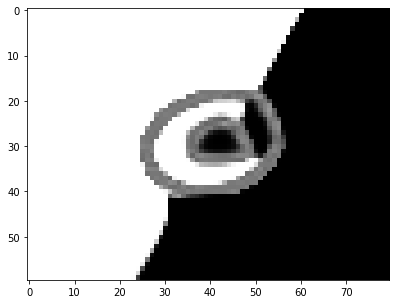

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(model(batch).cpu().detach().view(60, 80).numpy(), cmap='gray', vmin=-1, vmax=1)
plt.show()